In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

df = pd.read_csv("./data/train.csv")

In [2]:
"""
pre-processing
"""
import random
from sklearn.preprocessing import LabelEncoder

def pre_process(df, le_rnc=None):
    # shuffling
    ids = df["breath_id"].unique()
    random.shuffle(ids)
    df = df.set_index("breath_id").loc[ids].reset_index()
    
    # R and C
    df["rnc"] = df["R"].astype(str) + '_' + df["C"].astype(str)
    if le_rnc is None:
        le_rnc = LabelEncoder()
        le_rnc.fit(df.loc[:, "rnc"])
    df.loc[:, "rnc"] = le_rnc.transform(list(df.loc[:, "rnc"]))

    # time diff
    df.rename({"time_step": "t"}, axis=1, inplace=True)
    df["t_m1"] = df.groupby("breath_id")["t"].shift(-1)
    df["dt"] = df["t_m1"] - df["t"]
    df["dt"].fillna(method='ffill', inplace=True)
    df["dt2"] = df["dt"] ** 2

    # u_in - future and past values, 1st diff, and 1st derivative
    df["u_in_m1"] = df.groupby("breath_id")["u_in"].shift(-1).fillna(method="ffill")
    df["u_in_p1"] = df.groupby("breath_id")["u_in"].shift(1).fillna(method="bfill")
    df["d1_u_in"] = df["u_in_m1"] - df["u_in"]
    df["prime1_u_in"] = df["d1_u_in"] / df["dt"]

    # u_out - future and past values
    df["u_out_m1"] = df.groupby("breath_id")["u_out"].shift(-1).fillna(method="ffill")
    df["u_out_p1"] = df.groupby("breath_id")["u_out"].shift(1).fillna(method="bfill")

    # integration
    df["int1_u_in"] = (df["u_in"] * df["dt"]).cumsum()
    df["int2_u_in"] = (df["int1_u_in"] * df["dt"]).cumsum()
    
    return df, le_rnc

df, le_rnc = pre_process(df)

In [3]:
class Predictor:
    
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        
    def fit(self, df):
        breath_ids = df["breath_id"].unique()
        n_breath_ids = len(breath_ids)
        n_time_steps = len(df) // n_breath_ids
        print(f"Fitting. n_breath_ids {n_breath_ids}, n_time_steps {n_time_steps}")
        
        n_in = 5
        cols = ["rnc", "dt", "u_in", "d1_u_in", "prime1_u_in"]
        n_cols = len(cols)

        x = df[cols].to_numpy().reshape((n_breath_ids, n_time_steps, n_cols))[:, :n_in, :]
        x = x.reshape((n_breath_ids, n_in * n_cols))
        y = df["pressure"].to_numpy().reshape((n_breath_ids, n_time_steps))[:, 0]
        self.model_1.fit(x, y)
        
        df.loc[:, "pressure_p1"] = df.groupby("breath_id")["pressure"].shift(1)
        df_tmp = df.dropna()
        
        cols = ["rnc", "u_in", "u_out", "dt", "u_in_m1", "u_in_p1", "u_out_m1", "u_out_p1", "pressure_p1"]
        x = df_tmp[cols].to_numpy()
        y = df_tmp["pressure"].to_numpy()
        self.model_2.fit(x, y)
        
    def predict(self, df, verbose=False):
        breath_ids = df["breath_id"].unique()
        n_breath_ids = len(breath_ids)
        n_time_steps = len(df) // n_breath_ids
        print(f"Predicting. n_breath_ids {n_breath_ids}, n_time_steps {n_time_steps}")
        
        n_in = 5
        cols = ["rnc", "dt", "u_in", "d1_u_in", "prime1_u_in"]
        n_cols = len(cols)
        
        y_tot = np.zeros((n_breath_ids, n_time_steps))
        
        x = df[cols].to_numpy().reshape((n_breath_ids, n_time_steps, n_cols))[:, :n_in, :]
        x = x.reshape((n_breath_ids, n_in * n_cols))
        y = self.model_1.predict(x)
        y_tot[:, 0] = y
        
        cols = ["rnc", "u_in", "u_out", "dt", "u_in_m1", "u_in_p1", "u_out_m1", "u_out_p1"]
        n_cols = len(cols)
        x = df[cols].to_numpy().reshape((n_breath_ids, n_time_steps, n_cols))
        for step in range(n_time_steps - 1):
            if verbose:
                print(f"predicting t {step+1}")
            x_step = np.zeros((n_breath_ids, n_cols + 1))
            x_step[:, :-1] = x[:, step+1, :]
            x_step[:, -1] = y_tot[:, step]
            y_tot[:, step+1] = self.model_2.predict(x_step)
            
        return y_tot.reshape(-1)

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error

def get_score(predictor, df, n_folds=10):
    kfold = KFold(n_splits=n_folds, shuffle=False)
    scores_1, scores_2 = list(), list()
    for fold, (train_ids, test_ids) in enumerate(kfold.split(df)):
        df_train = df.iloc[train_ids, :]
        df_test = df.iloc[train_ids, :]
        y_test = df_test["pressure"]
        predictor.fit(df_train)
        yp_test = predictor.predict(df_test)
        score_1 = r2_score(y_test, yp_test)
        score_2 = mean_absolute_error(y_test, yp_test)
        scores_1.append(score_1)
        scores_2.append(score_2)
        print("fold", fold, "scores", score_1, score_2)
    return np.mean(scores_1), np.std(scores_1), np.mean(scores_2), np.std(scores_2)

import xgboost as xgb
model_1 = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                           learning_rate=0.05, max_depth=3, 
                           min_child_weight=1.7817, n_estimators=2200,
                           reg_alpha=0.4640, reg_lambda=0.8571,
                           subsample=0.5213, verbosity=0,
                           random_state=7, nthread=-1)
model_2 = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                           learning_rate=0.05, max_depth=2, 
                           min_child_weight=1.7817, n_estimators=500,
                           reg_alpha=0.4640, reg_lambda=0.8571,
                           subsample=0.5213, verbosity=0,
                           random_state=7, nthread=-1)


from sklearn.linear_model import Ridge
#model_1 = make_pipeline(RobustScaler(), Ridge(alpha=0.1, random_state=0))
#model_2 = make_pipeline(RobustScaler(), Ridge(alpha=0.1, random_state=0))

predictor = Predictor(model_1, model_2)
get_score(predictor, df, n_folds=2)

Fitting. n_breath_ids 37725, n_time_steps 80


/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predicting. n_breath_ids 37725, n_time_steps 80
fold 0 scores 0.8131015431179155 2.0104700017808477
Fitting. n_breath_ids 37725, n_time_steps 80


/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predicting. n_breath_ids 37725, n_time_steps 80
fold 1 scores 0.8142405409994472 1.9968350491953508


(0.8136710420586813,
 0.0005694989407658557,
 2.003652525488099,
 0.006817476292748426)

Fitting. n_breath_ids 75450, n_time_steps 80


/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Predicting. n_breath_ids 75450, n_time_steps 80
0.7715045391944017
1.9628034838222568


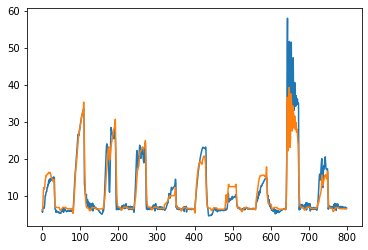

In [8]:
predictor.fit(df)
y = df["pressure"]
yp = predictor.predict(df)
plt.plot(y[:800])
plt.plot(yp[:800])
print(r2_score(yp, y))
print(mean_absolute_error(yp, y))

In [9]:
df_final = pd.read_csv("./data/test.csv")
assert len(df_final) == 4024000
df_final, le_rnc = pre_process(df_final, le_rnc)
df_final["yp"] = predictor.predict(df_final)
df_final[["id", "yp"]].to_csv("output.zip", index=False, header=["id", "pressure"], compression="zip")

Predicting. n_breath_ids 50300, n_time_steps 80
